In [1]:
from pymatgen import MPRester

with MPRester("API_KEY") as mp: 
    bdst = mp.get_bandstructure_by_material_id("mp-23040")  
    struct = mp.query("mp-23040", ["structure","nelect"])[0]["structure"]  

In [2]:
bdst.get_band_gap()  # affiche les données du band gap

{'direct': False, 'energy': 1.7000000000000002, 'transition': '\\Gamma-F'}

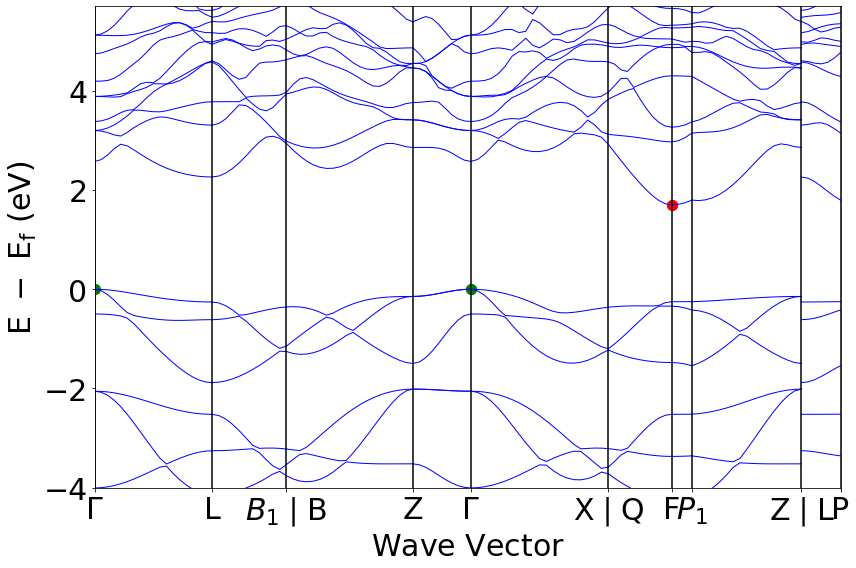

In [4]:
import pymatgen.electronic_structure.plotter as plotter
                     
# plot la structure de bandes en affichant le min (max) de la 1ère (dernière) bande de conduction (valence)    
    
blt = plotter.BSPlotter(bdst)  
blt.get_plot(vbm_cbm_marker=True).show()  

<IPython.core.display.Javascript object>


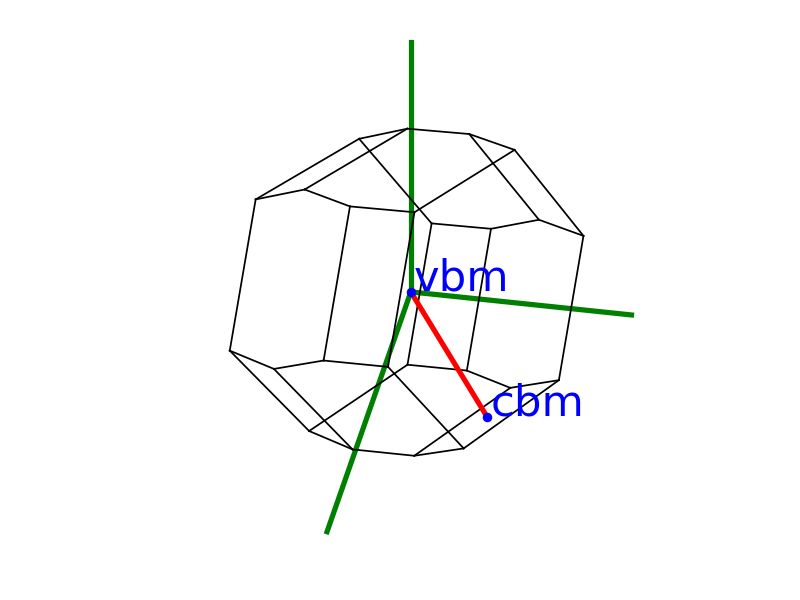

In [6]:
%matplotlib notebook     
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer    
import pymatgen.symmetry.bandstructure as b
from pymatgen.core.lattice import Lattice 
import matplotlib.pyplot as plt
import numpy as np                                                          

# plot la zone de brillouin et des lignes qui vont de son centre jusqu'au 
# min (max) de la 1ère (dernière) bande de conduction (valence) 

sp = SpacegroupAnalyzer(struct)                       
new_structure = sp.get_primitive_standard_structure()    

lattice = Lattice(bdst.kpoints[0].as_dict()['lattice']['matrix'])   

cbm = np.array(bdst.get_cbm()['kpoint'].as_dict()['fcoords'])    # coordonnées du minimum de la bande de conduction
vbm = np.array(bdst.get_vbm()['kpoint'].as_dict()['fcoords'])    # coordonnées du maximum de la bande de valence
 
label = {}
label['vbm'] = vbm     
label['cbm'] = cbm     

fig = plotter.plot_brillouin_zone(lattice,lines=[[cbm,vbm]],labels=label) 
fig.show() 

In [7]:
# permet de voir que les bandes de valence et de conduction sont
# les bandes numéros 15 et 16 
bdst.get_cbm(),bdst.get_vbm()    # affiche les données du cbm et du vbm

({'band_index': defaultdict(list, {<Spin.up: 1>: [16]}),
  'kpoint_index': [92, 93],
  'kpoint': <pymatgen.electronic_structure.bandstructure.Kpoint at 0x7efea48166d8>,
  'energy': 4.9375,
  'projections': {}},
 {'band_index': defaultdict(list, {<Spin.up: 1>: [14, 15]}),
  'kpoint_index': [0, 60, 61],
  'kpoint': <pymatgen.electronic_structure.bandstructure.Kpoint at 0x7efea4c79128>,
  'energy': 3.2375,
  'projections': {}})

<IPython.core.display.Javascript object>


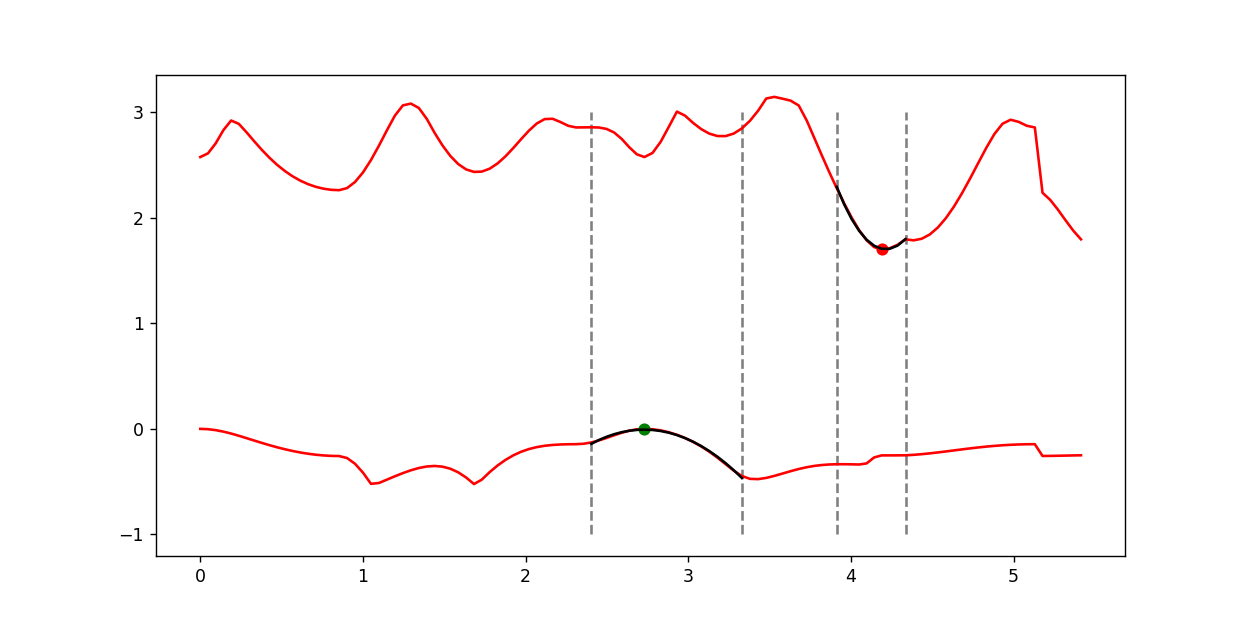

In [8]:
import matplotlib.pyplot as plot
 
# approximme les bandes par une parabole (entre les lignes pointillées)     
    
dic = blt.bs_plot_data()
distances = dic['distances']
energy = dic['energy']
vbm = dic['vbm']
cbm = dic['cbm']

x_data = [0.0]                            
for branch in distances:                   # rassemble les kpoints de toutes les branches en une seule
    x_data = np.append(x_data,branch[1:])  # liste en ne mettant qu'une fois les points doubles
    
y_data = energy[0]['1']       
for branch in energy[1:]:                      # rassemble les énergies de toutes les branches en une seule liste
    for j,band in enumerate(branch['1']):      # par bandes en ne mettant qu'une fois les points doubles
        y_data[j] = np.append(y_data[j],band[1:])  
        
# plot les données        
        
fig = plot.figure(figsize=(10,5))        
        
plot.plot(x_data,y_data[15],'r') 
plot.plot(x_data,y_data[16],'r') 
    
plot.plot(cbm[0][0],cbm[0][1],'ro')
plot.plot(vbm[1][0],vbm[1][1],'go')
         
index_1,index_2 = np.argmax(y_data[15][1:])+1,np.argmin(y_data[16])

plot.vlines(x_data[index_1-7],-1,3,color='grey',linestyle='dashed')
plot.vlines(x_data[index_1+12],-1,3,color='grey',linestyle='dashed') 
plot.vlines(x_data[index_2-6],-1,3,color='grey',linestyle='dashed')
plot.vlines(x_data[index_2+3],-1,3,color='grey',linestyle='dashed')

# approxime par une parabole

p_1 = np.poly1d(np.polyfit(x_data[index_1-7:index_1+13],y_data[15][index_1-7:index_1+13],2)) 
p_2 = np.poly1d(np.polyfit(x_data[index_2-6:index_2+4],y_data[16][index_2-6:index_2+4],2))
  
aprox_y_1 = [p_1(x) for x in x_data[index_1-7:index_1+13]]  
aprox_y_2 = [p_2(x) for x in x_data[index_2-6:index_2+4]]   

plot.plot(x_data[index_1-7:index_1+13],aprox_y_1,color='black')
plot.plot(x_data[index_2-6:index_2+4],aprox_y_2,color='black')
    
plot.show()  

In [9]:
import scipy.constants as s

# calcule la masse effective en multiple de la masse d'un électron

a = new_structure.lattice.reciprocal_lattice.a*10**(-10)  # dimension du réseau pour passer en mètres

eff_mass_val = (s.hbar**2)/(2*p_1[2]*s.e*a*a*s.m_e)      # p_i[n] renvoie le coefficient de degré n du polynome i 
eff_mass_cond = (s.hbar**2)/(2*p_2[2]*s.e*a*a*s.m_e)     # s.e pour passer d'électrons-volts aux joules

print(eff_mass_val,'*m_e')
print(eff_mass_cond,'*m_e')

-1.0303285281387538 *m_e
0.20096194949526267 *m_e
